In [1]:
import torchvision
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

import matplotlib.pyplot as plt

from skimage.feature import hog
from skimage import data, exposure
from sklearn.model_selection import train_test_split

import timeit
from sklearn.metrics import accuracy_score
from snorkel.labeling import labeling_function
from snorkel.labeling import LFApplier
from snorkel.labeling import LFAnalysis
from snorkel.labeling.model import LabelModel
from sklearn import svm


import torch
import torch.nn as nn
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix

In [2]:
np.random.seed(0)

# Data Processing

In [3]:
transform = transforms.Compose([transforms.ToTensor()])
train_data = torchvision.datasets.FashionMNIST(root = 'FashionMNIST/processed/training.pt', train=True, download=True, transform=transform)
train_data_loader = torch.utils.data.DataLoader(train_data,batch_size=train_data.__len__(),shuffle=True)
train_images, train_labels = next(iter(train_data_loader))

In [4]:
test_data = torchvision.datasets.FashionMNIST(root = 'FashionMNIST/processed/testing.pt', train=False, download=True, transform=transform)
test_data_loader = torch.utils.data.DataLoader(test_data,batch_size=test_data.__len__(),shuffle=True)
test_images, test_labels = next(iter(test_data_loader))

In [5]:
def feature_processing(image):
    return image.cpu().detach().numpy()

In [6]:
def target_processing(label):
    return label.cpu().detach().numpy().item()

In [7]:
train_images = list(map(feature_processing, train_images))
train_labels = list(map(target_processing, train_labels))
test_images = list(map(feature_processing, test_images))
test_labels = list(map(target_processing, test_labels))

# Feature Extraction & Modeling

I pull 10,000 labels from the database. We will build labelling functions based on these labels, which will be used to generate the "weak" labels of the entire training dataset. 

In [10]:
num_sample = 10000
chosen_index = np.random.choice(len(train_images), num_sample)
train_images_sample = np.array(train_images)[chosen_index]
train_labels_sample = np.array(train_labels)[chosen_index]
chosen_index = np.random.choice(len(test_images), num_sample)
test_images_sample = np.array(test_images)[chosen_index]
test_labels_sample = np.array(test_labels)[chosen_index]

## KNN on raw pixel

In [11]:
def baseline_knn_processing(image):
    return np.ravel(image)

In [12]:
X_train = list(map(baseline_knn_processing, train_images_sample))
y_train = train_labels_sample
X_test = list(map(baseline_knn_processing, test_images_sample))
y_test = test_labels_sample

In [13]:
neigh_1 = KNeighborsClassifier(n_neighbors=12, p = 1)
neigh_1.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=12, p=1)

## KNN on HOG feature extraction

In [14]:
def hog_processing(image):
    image = np.squeeze(image)
    fd, hog_image = hog(image, orientations=8, pixels_per_cell=(4, 4),
                        cells_per_block=(1, 1), visualize=True)
    return fd

In [15]:
X_train = list(map(hog_processing, train_images_sample))
y_train = train_labels_sample
X_test = list(map(hog_processing, test_images_sample))
y_test = test_labels_sample

In [16]:
hog_knn_1 = KNeighborsClassifier(n_neighbors=12, p = 1)
hog_knn_1.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=12, p=1)

## KNN on HOG feature extraction

In [17]:
hog_svm_1 = svm.SVC(C = 1, kernel = 'rbf')
hog_svm_1.fit(X_train, y_train)

SVC(C=1)

# Weak Supervision

We leverage the power of weak supervision (https://www.snorkel.org/blog/weak-supervision) to hadle the sparse label problem. 

## Generate labelling functions

In [18]:
@labeling_function()
def model_1(image):
    x = baseline_knn_processing(image) 
    x = np.expand_dims(x, axis=0)
    return neigh_1.predict(x)[0]

In [19]:
@labeling_function()
def model_2(image):
    x = hog_processing(image)
    x = np.expand_dims(x, axis=0)
    return hog_knn_1.predict(x)[0]

In [20]:
@labeling_function()
def model_3(image):
    x = hog_processing(image)
    x = np.expand_dims(x, axis=0)
    return hog_svm_1.predict(x)[0]

## Apply labelling functions

We apply labeling functions on 10,000 of the queried data points and fit the LabelModel. This LabelModel handles the conflict among different labeling functions and attampt to decorrelate the labeling functions. Otherwise, we are double-counting them.

In [22]:
lfs = [model_1, model_2, model_3]
applier = LFApplier(lfs)
L_train = applier.apply(train_images_sample)
LFAnalysis(L_train, lfs).lf_summary()

10000it [11:55, 13.98it/s]


,j,Polarity,Coverage,Overlaps,Conflicts
model_1,0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]",1.0,1.0,0.1897
model_2,1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]",1.0,1.0,0.1897
model_3,2,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]",1.0,1.0,0.1897


In [23]:
label_model = LabelModel(cardinality=10, verbose=True)
label_model.fit(L_train=L_train, n_epochs=500, log_freq=100, seed=123)

## Evaluation

In [24]:
label_model_acc = label_model.score(L=L_train, Y=np.array(y_train), tie_break_policy="random")["accuracy"]
print(f"{'Label Model Accuracy:':<25} {label_model_acc * 100:.1f}%")

Label Model Accuracy:     90.7%


In [25]:
for i in range(len(lfs)):
    y_pred = L_train[:,i]
    print(accuracy_score(y_train, y_pred))

0.8506
0.8578
0.9468


## Generate weak label of the training set

In [63]:
L_train_all = applier.apply(train_images)
y_pred_train = label_model.predict(L_train_all)

60000it [1:11:20, 14.02it/s]


## Baseline Weak Supervision on Test Set

In [28]:
lfs = [model_1, model_2, model_3]
applier = LFApplier(lfs)
L_test = applier.apply(test_images_sample)
LFAnalysis(L_test, lfs).lf_summary()

10000it [11:49, 14.09it/s]


,j,Polarity,Coverage,Overlaps,Conflicts
model_1,0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]",1.0,1.0,0.2138
model_2,1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]",1.0,1.0,0.2138
model_3,2,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]",1.0,1.0,0.2138


In [54]:
for i in range(len(lfs)):
    y_pred = L_test[:,i]
    print(accuracy_score(y_pred, y_test))

0.8253
0.8391
0.8701


In [29]:
y_pred = label_model.predict(L_test)

In [30]:
accuracy_score(y_test, y_pred)

0.8701

Accuracy of the final labelling model = 87 %

# Final CNN Model

Generate traning dataset using label generatef from weak supervision

In [78]:
batch_size = 100
train_images_tensor = torch.Tensor(train_images)
y_pred_tensor = torch.Tensor(y_pred_train).long()
dataset_train = torch.utils.data.TensorDataset(train_images_tensor,y_pred_tensor)
train_data_loader = torch.utils.data.DataLoader(dataset_train, batch_size = batch_size)

In [79]:
test_data = torchvision.datasets.FashionMNIST(root = 'FashionMNIST/processed/testing.pt', train=False, download=True, transform=transform)
test_data_loader = torch.utils.data.DataLoader(test_data,batch_size=batch_size,shuffle=True)

In [80]:
class FashionCNN(nn.Module):
    
    def __init__(self):
        super(FashionCNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out

In [81]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = FashionCNN()
model.to(device)

error = nn.CrossEntropyLoss()

learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [82]:
num_epochs = 20
count = 0
# Lists for visualization of loss and accuracy 
loss_list = []
iteration_list = []
accuracy_list = []

# Lists for knowing classwise accuracy
predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    print(epoch)
    for images, labels in train_data_loader:
        # Transfering images and labels to GPU if available
        images, labels = images.to(device), labels.to(device)
    
        train = Variable(images.view(batch_size, 1, 28, 28))
        labels = Variable(labels)
        
        # Forward pass 
        outputs = model(train)
        loss = error(outputs, labels)
        
        # Initializing a gradient as 0 so there is no mixing of gradient among the batches
        optimizer.zero_grad()
        
        #Propagating the error backward
        loss.backward()
        
        # Optimizing the parameters
        optimizer.step()
    
        count += 1
    
    # Testing the model
    
        if not (count % 50):    # It's same as "if count % 50 == 0"
            total = 0
            correct = 0
        
            for images, labels in test_data_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
            
                test = Variable(images.view(batch_size, 1, 28, 28))
            
                outputs = model(test)
            
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
            
                total += len(labels)
            
            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        
        if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))

0
Iteration: 500, Loss: 0.3006629943847656, Accuracy: 84.5199966430664%
1
Iteration: 1000, Loss: 0.25644466280937195, Accuracy: 85.1500015258789%
2
Iteration: 1500, Loss: 0.10757467150688171, Accuracy: 84.62999725341797%
3
Iteration: 2000, Loss: 0.20287494361400604, Accuracy: 85.66999816894531%
4
Iteration: 2500, Loss: 0.4113755524158478, Accuracy: 86.04999542236328%
Iteration: 3000, Loss: 0.15375161170959473, Accuracy: 85.66999816894531%
5
Iteration: 3500, Loss: 0.15637081861495972, Accuracy: 85.25999450683594%
6
Iteration: 4000, Loss: 0.16172295808792114, Accuracy: 85.93999481201172%
7
Iteration: 4500, Loss: 0.0985352024435997, Accuracy: 85.40999603271484%
8
Iteration: 5000, Loss: 0.14392690360546112, Accuracy: 86.32999420166016%
9
Iteration: 5500, Loss: 0.3665245473384857, Accuracy: 85.8699951171875%
Iteration: 6000, Loss: 0.08244329690933228, Accuracy: 85.8699951171875%
10
Iteration: 6500, Loss: 0.12290564179420471, Accuracy: 85.38999938964844%
11
Iteration: 7000, Loss: 0.120798416

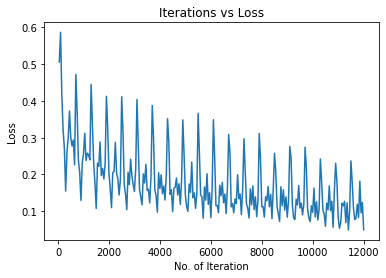

In [83]:
plt.plot(iteration_list, loss_list)
plt.xlabel("No. of Iteration")
plt.ylabel("Loss")
plt.title("Iterations vs Loss")
plt.show()

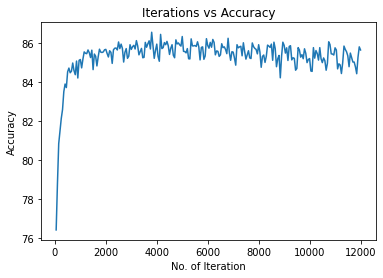

In [84]:
plt.plot(iteration_list, accuracy_list)
plt.xlabel("No. of Iteration")
plt.ylabel("Accuracy")
plt.title("Iterations vs Accuracy")
plt.show()

Accuracy of the final model = 87%